### Basic ISC



#### Import modules

In [1]:
import sys
sys.path.insert(1, '../')
import matplotlib.pyplot as plt
%matplotlib inline
import os, nilearn, pickle, glob,shutil
from nilearn import plotting, maskers, datasets
import numpy as np
from nltools.data import Brain_Data
from nltools.mask import expand_mask, roi_to_brain
from nilearn.plotting import view_img_on_surf, view_img
from nltools.stats import isc, threshold, fdr
from tqdm import tqdm

import pandas as pd
from statsmodels.stats.multitest import multipletests
from utils import *
import warnings
warnings.simplefilter("ignore")

#### Setup variables and filenames

In [2]:
recompute_results      = True
pairwise_flag          = True
n_iter                 = 5000
alpha                  = 0.05
twin_data_file         = '../../data/00_dataset_info/twin_df.csv'
fmri_data_file         = '../../data/03_extract_ts_aus/ts_array_shen268_pauli16_aan9.npy'
all293_rois_file       = '../../data/02_rois_masks_maps/allcombined.nii'
masker_prefitting_file = '../../data/02_rois_masks_maps/func.nii.gz'
isc_npy_file           = '../../data/05_results/aus_isc_perm5000_FDRq05.npy'
isc_result_file_phase  = '../../data/05_results/aus_isc_phase1000_FDRq05.nii'
isc_result_file_perm   = '../../data/05_results/aus_isc_perm1000_FDRq05.nii'

#### Load viewer info, set up masker, load timeseries

In [3]:
# load subject info
twin_df = pd.read_csv(twin_data_file)
sub_list = list(np.hstack((twin_df['twin_A_id'].values, twin_df['twin_B_id'].values)))
print("Number of subjects: " + str(len(sub_list)))

# prepare masker
isc_masker            = maskers.NiftiLabelsMasker(all293_rois_file);
isc_masker.fit(masker_prefitting_file);
print("Set up ISC masker")

# load timeseries, swap axes
ts_array = np.load(fmri_data_file)
ts_data = np.swapaxes(ts_array, 0, 2)
ts_data = np.swapaxes(ts_data, 0, 1)
print("Shape of time series structure: " + str(ts_data.shape))

Number of subjects: 200
Set up ISC masker
Shape of time series structure: (380, 293, 200)


#### Basic ISC analysis 
(via resampling stats)

In [4]:
# set up mask
mask = Brain_Data(all293_rois_file)
mask_x = expand_mask(mask)
    
# run isc permutation/bootstrap analysis
p_results = []
isc_results = []
for curr_roi in tqdm(range(293)):
        #print(curr_roi)
        data_roi_df = pd.DataFrame(ts_data[:,curr_roi,:], columns = list(np.hstack((twin_df.twin_A_id.values, twin_df.twin_B_id.values)).flatten()) )
        stats_boot = isc(data_roi_df, method='bootstrap', n_samples=n_iter, return_null=True)
        #print(f"ISC: {stats_boot['isc']:.02}, p = {stats_boot['p']:.03}")
        p_results.append(stats_boot['p'])
        isc_results.append(stats_boot['isc'])

if recompute_results:
    # we always compute the basic resampling stats (only not if phaserand), here just save for later use 
    p = np.asarray(p_results);  p = np.reshape(p, (293,1)).T
    ISC = np.asarray(isc_results); ISC = np.reshape(ISC, (293,1)).T
    ISC[np.isnan(ISC)]      = 0
    q                       = multipletests(p[0, :], method='fdr_by')[1]
    corrected               = q[np.newaxis, :] < alpha
    ISC[corrected == False] = 0
    curr_isc = np.reshape(ISC, (293,1)).T
    np.save(isc_npy_file, curr_isc)

100%|█████████████████████████████████████████| 293/293 [02:35<00:00,  1.89it/s]


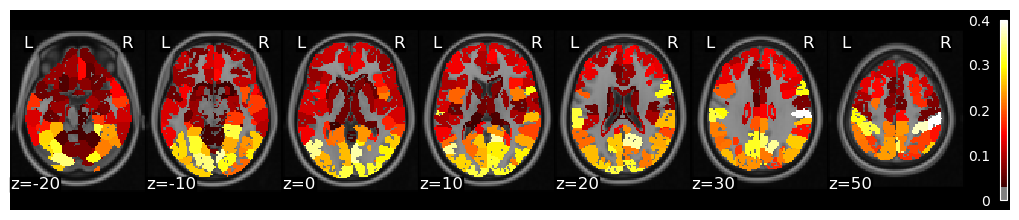

In [5]:
# map isc results back to brain
isc_r_brain, isc_p_brain = roi_to_brain(pd.Series(isc_results), mask_x), roi_to_brain(pd.Series(p_results), mask_x)
result_image = threshold(isc_r_brain, isc_p_brain, thr=fdr(isc_p_brain.data, q = alpha)).to_nifti()

# visualize results
fig = plt.figure(figsize=(10, 2))
nilearn.plotting.plot_stat_map(    result_image, 
                                   bg_img       = '../../data/02_rois_masks_maps/MNI152_T1_2mm.nii.gz',
                                   threshold    = 0.03,  #additional threshold for visualization
                                   vmax         = 0.4, 
                                   draw_cross   = False,
                                   display_mode = 'z',
                                   cut_coords   = [ -20, -10, 0, 10, 20, 30, 50],
                                   annotate     = True,
                                   figure = fig);


#### Basic ISC analysis 
(via phase randomization stats)

In [6]:
# set up mask
mask = Brain_Data(all293_rois_file)
mask_x = expand_mask(mask)
    
# run isc permutation/bootstrap analysis
p_results = []
isc_results = []
for curr_roi in tqdm(range(293)):
        #print(curr_roi)
        data_roi_df = pd.DataFrame(ts_data[:,curr_roi,:], columns = list(np.hstack((twin_df.twin_A_id.values, twin_df.twin_B_id.values)).flatten()) )
        stats_phase = isc(data_roi_df, method='phase_randomize', n_samples=n_iter, return_null=True)
        p_results.append(stats_phase['p'])
        isc_results.append(stats_phase['isc'])

100%|███████████████████████████████████████| 293/293 [1:24:00<00:00, 17.20s/it]


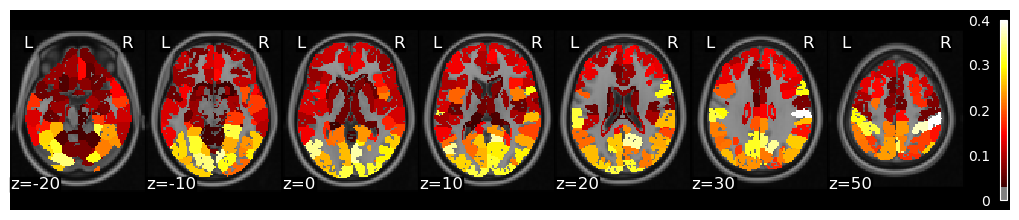

In [7]:
# map isc results back to brain
isc_r_brain, isc_p_brain = roi_to_brain(pd.Series(isc_results), mask_x), roi_to_brain(pd.Series(p_results), mask_x)
result_image = threshold(isc_r_brain, isc_p_brain, thr=fdr(isc_p_brain.data, q = alpha)).to_nifti()

# visualize results
fig = plt.figure(figsize=(10, 2))
nilearn.plotting.plot_stat_map(    result_image, 
                                   bg_img       = '../../data/02_rois_masks_maps/MNI152_T1_2mm.nii.gz',
                                   threshold    = 0.03,  #additional threshold for visualization
                                   vmax         = 0.4, 
                                   draw_cross   = False,
                                   display_mode = 'z',
                                   cut_coords   = [ -20, -10, 0, 10, 20, 30, 50],
                                   annotate     = True,
                                   figure = fig);


#### Basic ISC 
(via phase randomization from BrainIAK)

Now computing phaseshift ISC ...


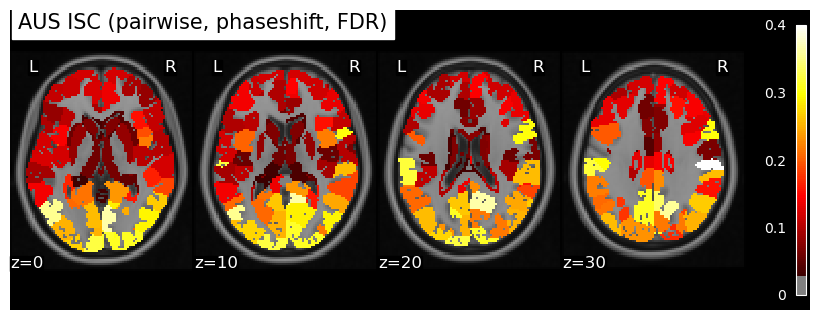

In [8]:
if recompute_results:
    
    # submit to ISC analysis, takes about 15-20 minutes on normal machine with 1000 shifts
    print('Now computing phaseshift ISC ...')
    ISC, p = partly_phaseshift_isc(ts_data, pairwise = pairwise_flag, summary_statistic = np.median,
                                    n_shifts = n_iter, return_distribution = False)
    ISC[np.isnan(ISC)] = 0
    
    # Stats correction 
    q                               = multipletests(p[0, :], method='fdr_by')[1]
    corrected                       = q[np.newaxis, :] < alpha
    ISC[corrected == False]         = 0

    # Map to brain space
    curr_isc = np.reshape(ISC, (293,1)).T
    curr_img = isc_masker.inverse_transform(curr_isc);
    curr_img.to_filename(isc_result_file_phase)

else:
    curr_img = nilearn.image.load_img(isc_result_file_phase)

# Plot
fig = plt.figure(figsize=(8, 3))
nilearn.plotting.plot_stat_map(nilearn.image.index_img(curr_img,0), 
                                   threshold    = 0.03, 
                                   bg_img       = '../../data/02_rois_masks_maps/MNI152_T1_2mm.nii.gz',
                                   vmax         = 0.4, 
                                   draw_cross   = False,
                                   display_mode = 'z',
                                   cut_coords   = [ 0, 10, 20, 30],
                                   annotate     = True,
                                   title = 'AUS ISC (pairwise, phaseshift, FDR)',
                                   figure = fig);
plt.show();

#### Basic ISC 
(via permutation from BrainIAK)

Assuming 200 subjects with 380 time points and 293 voxel(s) or ROI(s).
Now computing permutation ISC ...


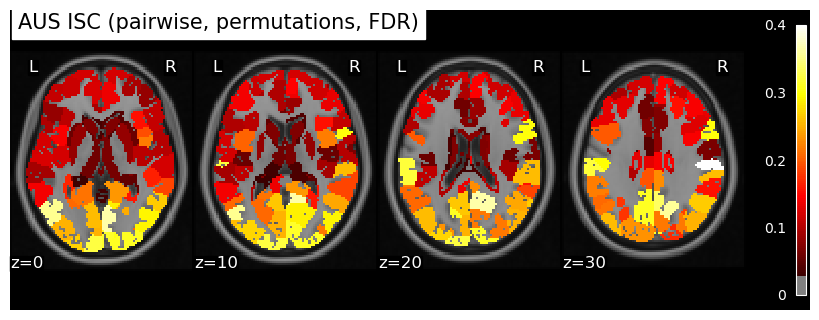

In [9]:
if recompute_results:
    
    # first, compute the individual isc and flatten into a one-subject-per-line matrix 
    input_isc = partly_isc(ts_data, pairwise=True, summary_statistic=None)
    
    # Compute permutation ISC
    print('Now computing permutation ISC ...')
    ISC, p, distribution = partly_permutation_isc(input_isc, pairwise= True, summary_statistic = 'median', n_permutations = n_iter)
    
    # Correction 
    p = np.reshape(p, (293,1)).T
    ISC[np.isnan(ISC)]      = 0
    q                       = multipletests(p[0, :], method='fdr_by')[1]
    corrected               = q[np.newaxis, :] < alpha
    ISC[corrected == False] = 0

    # Map statistical results into brain space
    curr_isc = np.reshape(ISC, (293,1)).T
    curr_img = isc_masker.inverse_transform(curr_isc);
    curr_img.to_filename(isc_result_file_perm)
    np.save(isc_npy_file, curr_isc)

else:
    curr_img = nilearn.image.load_img(isc_result_file_perm)

# Plot
fig = plt.figure(figsize=(8, 3))
nilearn.plotting.plot_stat_map(nilearn.image.index_img(curr_img,0), 
                                       bg_img       = '../../data/02_rois_masks_maps/MNI152_T1_2mm.nii.gz',
                                       threshold    = 0.03, 
                                       vmax         = 0.4, 
                                       draw_cross   = False,
                                       display_mode = 'z',
                                       cut_coords   = [ 0, 10, 20, 30],
                                       annotate     = True,
                                       title = 'AUS ISC (pairwise, permutations, FDR)',
                                       figure = fig);
plt.show();

#### Additionally, take a far more conservative approach

Assuming 200 subjects with 380 time points and 293 voxel(s) or ROI(s).
Now computing permutation ISC ...


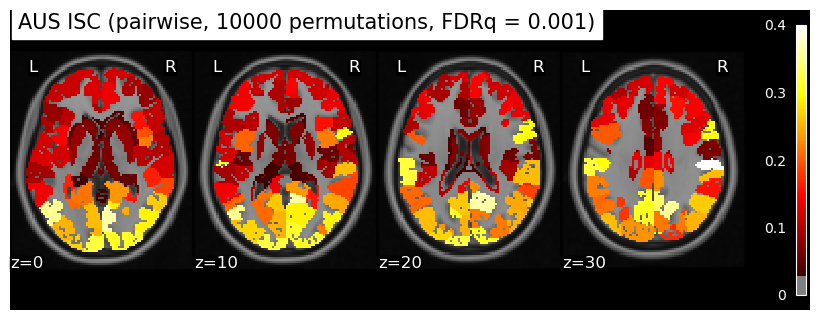

In [10]:
    
# first, compute the individual isc and flatten into a one-subject-per-line matrix 
input_isc = partly_isc(ts_data, pairwise=True, summary_statistic=None)
    
# Compute permutation ISC
print('Now computing permutation ISC ...')
ISC, p, distribution = partly_permutation_isc(input_isc, pairwise= True, summary_statistic = 'median', n_permutations = 10000)
    
# Correction 
p = np.reshape(p, (293,1)).T
ISC[np.isnan(ISC)]      = 0
q                       = multipletests(p[0, :], method='fdr_by')[1]
corrected               = q[np.newaxis, :] < 0.001
ISC[corrected == False] = 0

# Map statistical results into brain space
curr_isc = np.reshape(ISC, (293,1)).T
curr_img = isc_masker.inverse_transform(curr_isc);

# Plot
fig = plt.figure(figsize=(8, 3))
nilearn.plotting.plot_stat_map(nilearn.image.index_img(curr_img,0), 
                                       bg_img       = '../../data/02_rois_masks_maps/MNI152_T1_2mm.nii.gz',
                                       threshold    = 0.03, 
                                       vmax         = 0.4, 
                                       draw_cross   = False,
                                       display_mode = 'z',
                                       cut_coords   = [ 0, 10, 20, 30],
                                       annotate     = True,
                                       title = 'AUS ISC (pairwise, 10000 permutations, FDRq = 0.001)',
                                       figure = fig);
plt.show();

#### Additional explorations of variants of computing and testing ISC

In [11]:
curr_roi    = 47
data_roi_df = pd.DataFrame(ts_data[:,curr_roi,:], columns = list(np.hstack((twin_df.twin_A_id.values, twin_df.twin_B_id.values)).flatten()) )

In [12]:
stats_circle = isc(data_roi_df, method='circle_shift', n_samples=5000, return_null=True)
print(f"ISC: {stats_circle['isc']:.02}, p = {stats_circle['p']:.03}")

ISC: 0.27, p = 0.0002


In [13]:
stats_phase = isc(data_roi_df, method='phase_randomize', n_samples=5000, return_null=True)
print(f"ISC: {stats_phase['isc']:.02}, p = {stats_phase['p']:.03}")

ISC: 0.27, p = 0.0002


In [14]:
stats_boot = isc(data_roi_df, method='bootstrap', n_samples=5000, return_null=True)
print(f"ISC: {stats_boot['isc']:.02}, p = {stats_boot['p']:.03}")

ISC: 0.27, p = 0.0002


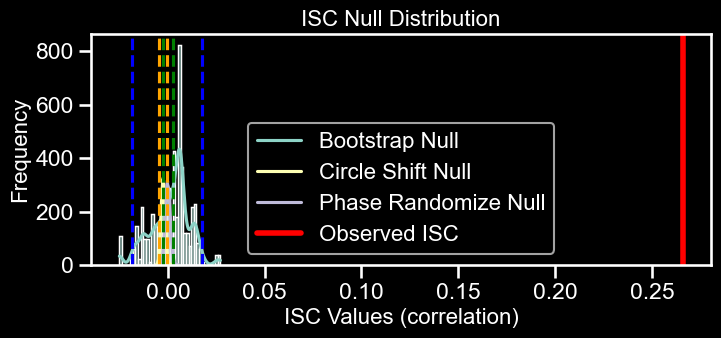

In [15]:
fs = 16

sns.set(style="ticks", context="talk")
plt.style.use("dark_background")

plt.figure(figsize=(8,3));
sns.histplot(stats_boot['null_distribution'] - stats_boot['isc'], kde=True, label='Bootstrap');
sns.histplot(stats_circle['null_distribution'], kde=True, label='Bootstrap');
sns.histplot(stats_phase['null_distribution'], kde=True, label='Bootstrap');
plt.ylabel('Frequency', fontsize= fs);
plt.xlabel('ISC Values (correlation)', fontsize= fs);
plt.title('ISC Null Distribution', fontsize= fs);
plt.axvline(stats_boot['isc'], linestyle='-', color='red', linewidth=4);
plt.legend(['Bootstrap Null','Circle Shift Null', 'Phase Randomize Null', 'Observed ISC'], fontsize=fs);
    
plt.axvline(stats_boot['ci'][0] - stats_boot['isc'], linestyle='--', color='blue');
plt.axvline(stats_boot['ci'][1] - stats_boot['isc'], linestyle='--', color='blue');
    
plt.axvline(stats_circle['ci'][0], linestyle='--', color='orange');
plt.axvline(stats_circle['ci'][1], linestyle='--', color='orange');
    
plt.axvline(stats_phase['ci'][0], linestyle='--', color='green');
plt.axvline(stats_phase['ci'][1], linestyle='--', color='green');
plt.show()

0
ISC: 0.062, p = 0.0002


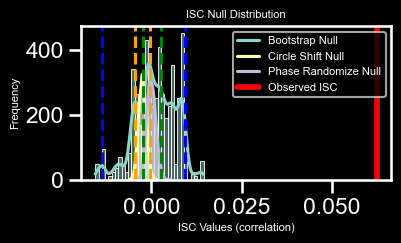

1
ISC: 0.075, p = 0.0002


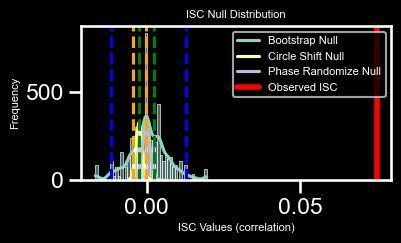

2
ISC: 0.15, p = 0.0002


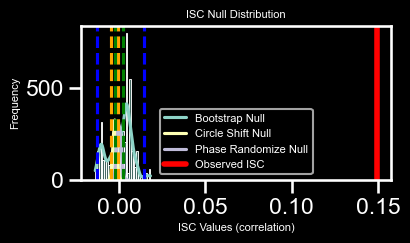

3
ISC: 0.048, p = 0.0002


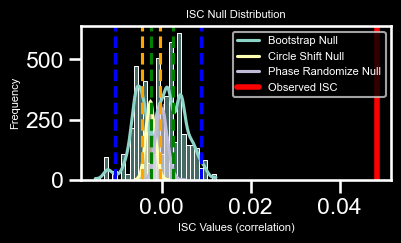

4
ISC: 0.14, p = 0.0002


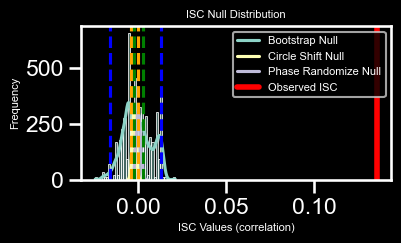

5
ISC: 0.12, p = 0.0002


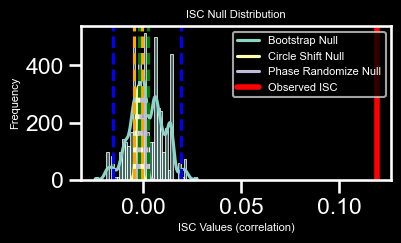

6
ISC: 0.095, p = 0.0002


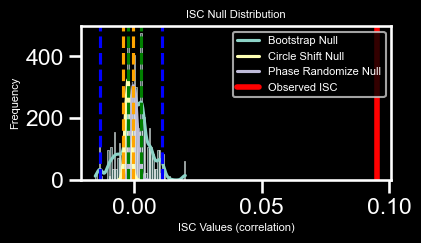

7
ISC: 0.082, p = 0.0002


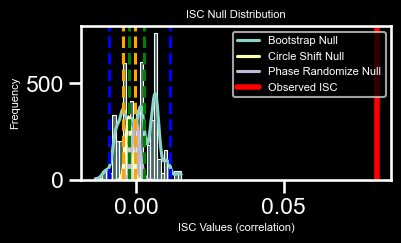

8
ISC: 0.12, p = 0.0002


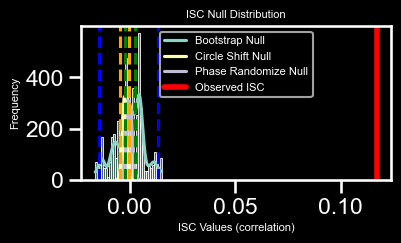

9
ISC: 0.14, p = 0.0002


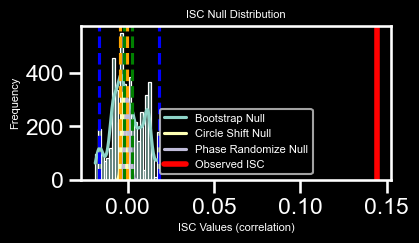

In [16]:

p_results = []
isc_results = []

for curr_roi in range(10): #removed all 293 to make notebook smaller
    print(curr_roi)
    data_roi_df = pd.DataFrame(ts_data[:,curr_roi,:], columns = list(np.hstack((twin_df.twin_A_id.values, twin_df.twin_B_id.values)).flatten()) )
    stats_boot = isc(data_roi_df, method='bootstrap', n_samples=5000, return_null=True)
    print(f"ISC: {stats_boot['isc']:.02}, p = {stats_boot['p']:.03}")
    p_results.append(stats_boot['p'])
    isc_results.append(stats_boot['isc'])


    fs = 8
    plt.figure(figsize=(4,2));
    sns.histplot(stats_boot['null_distribution'] - stats_boot['isc'], kde=True, label='Bootstrap');
    sns.histplot(stats_circle['null_distribution'], kde=True, label='Bootstrap');
    sns.histplot(stats_phase['null_distribution'], kde=True, label='Bootstrap');
    plt.ylabel('Frequency', fontsize= fs);
    plt.xlabel('ISC Values (correlation)', fontsize= fs);
    plt.title('ISC Null Distribution', fontsize= fs);
    plt.axvline(stats_boot['isc'], linestyle='-', color='red', linewidth=4);
    plt.legend(['Bootstrap Null','Circle Shift Null', 'Phase Randomize Null', 'Observed ISC'], fontsize=fs);
    
    plt.axvline(stats_boot['ci'][0] - stats_boot['isc'], linestyle='--', color='blue');
    plt.axvline(stats_boot['ci'][1] - stats_boot['isc'], linestyle='--', color='blue');
    
    plt.axvline(stats_circle['ci'][0], linestyle='--', color='orange');
    plt.axvline(stats_circle['ci'][1], linestyle='--', color='orange');
    
    plt.axvline(stats_phase['ci'][0], linestyle='--', color='green');
    plt.axvline(stats_phase['ci'][1], linestyle='--', color='green');
    plt.show()

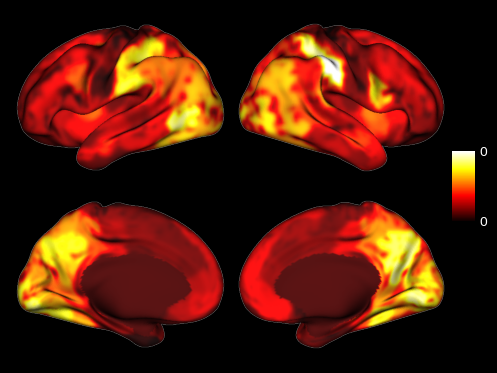

In [17]:
from surfplot import Plot
from neuromaps.datasets import fetch_fslr
from neuromaps.transforms import mni152_to_fslr


#import os
#os.system('/usr/bin/Xvfb :99 -screen 0 1024x768x24 &')
#os.environ['DISPLAY'] = ':99'

import panel as pn
pn.extension('vtk')





# Fetch fsLR surfaces from neuromaps
surfaces = fetch_fslr()
lh, rh = surfaces['inflated']
sulc_lh, sulc_rh = surfaces['sulc']

# Convert volumetric MNI data to fsLR surface
gii_lh, gii_rh = mni152_to_fslr(nilearn.image.smooth_img(result_image, 4), method='linear')

# Plot example ROI on surface
p = Plot(surf_lh=lh, surf_rh=rh, brightness=.7)
p.add_layer({'left': gii_lh, 'right': gii_rh}, cmap='hot', color_range=(0, 0.4))
cbar_kws = dict(location='right', draw_border=False, aspect=3,
                shrink=.2, decimals=0, pad=0, n_ticks=2)
fig = p.build(cbar_kws=cbar_kws)